### The idea here is to calculate tf-idf for all the words in Obama's speeches, then take the 100 with the highest average or 100 with highest max value, maybe cluster them, then plot them as a time series with their tf-idf values for all the speeches and see if any travel together.

In [2]:
import os
import re
import unicodedata
import numpy as np
import pandas as pd
import warnings
import nltk
from nltk.corpus import stopwords
import en_core_web_md
import matplotlib.pyplot as plt
import plotly.express as px
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import defaultdict
from textblob import TextBlob
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import sent_tokenize
import pprint # pretty print for easy printing of ordered dictionary
import spacy
spacy.load('en_core_web_md')
from nltk.corpus import cmudict
nltk.download("punkt")
from nltk.stem import WordNetLemmatizer
nltk.download ('wordnet')
# Time series clustering
import math
# https://tslearn.readthedocs.io/en/stable/
from tslearn.clustering import TimeSeriesKMeans

[nltk_data] Downloading package punkt to /home/muddy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/muddy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/muddy/.local/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


### Load up some speeches

In [3]:
# Load up the files
paths = ['./speeches/'] 
list_of_files = []

dates = pd.read_csv('dateSpeeches.csv')
for path in paths:
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.txt'):
                list_of_files.append(os.path.join(root,file))

speeches = []
for file in list_of_files:
    with open(file, encoding='utf-8') as f:
        #print(file)
        text = f.read()
    f.close()
    speeches.append(text)

#clean out goofy unicode  space characters 
speeches = [unicodedata.normalize("NFKD", speech) for speech in speeches if len(speech)>0 ]

# remove [stuff] in between square brackets
def remove_bracket(text):
    return re.sub('(\[[^w]*\]\s)', '',text)
speeches = [remove_bracket(speech) for speech in speeches]

# lemmatize text with spacy
nlp = spacy.load("en_core_web_md", exclude=["parser", "ner"])
for i, doc in enumerate(nlp.pipe(speeches)):
    words_lemmas_list = [token.lemma_ for token in doc]
    speeches[i]= ' '.join(words_lemmas_list)
    
# Remove punctuation - only care about words here
speeches = [re.sub(r'[^\w\s]', '', speech) for speech in speeches]

# remove numbers
speeches = [re.sub(r'\d', '', speech) for speech in speeches]

# Clean up whitespace
speeches = [re.sub('[\s+]', ' ', speech) for speech in speeches]
    
# Combine speeches and filenames
speeches = list(zip(speeches, list_of_files))
    
def get_source(text):
    regex = "[^./][a-zA-Z]+[^/]"
    string = re.findall(regex, str(text))[0]
    if string == 'speeches': string = 'oba'
    if string == 'NYTimes': string = 'nyt'
    return string.lower()

def get_date(text):
    regex = "([0-9]+[\-][0-9]+[\-][0-9]+)"
    return re.findall(regex, str(text))[0]

def get_filename(text):
    regex = "[-]([a-zA-Z]+)"
    return re.findall(regex, str(text))[0]

cols = ['text', 'filepath']
text_df = pd.DataFrame(speeches, columns=cols)
text_df['date'] = text_df['filepath'].apply(get_date)
text_df['date'] = pd.to_datetime(text_df['date'], format='%Y-%m-%d')
text_df['source'] = text_df['filepath'].apply(get_source)
text_df.set_index('date', inplace=True)
text_df.head(3)

text  \
date                                                            
2014-07-01  good afternoon  everybody  one year ago this m...   
2009-12-25  good morning  everybody  I want to take just a...   
2008-11-05  hello  Chicago     if there be anyone out ther...   

                                             filepath source  
date                                                          
2014-07-01      ./speeches/2014-07-01-Immigration.txt    oba  
2009-12-25  ./speeches/2009-12-25-UnderwearBomber.txt    oba  
2008-11-05     ./speeches/2008-11-05-ObamaElected.txt    oba

### <A HREF="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html">sk-learn TfidfVectorizer</A>

### TF-IDF Vectorizer

In [4]:
# remove stopwords
stop_words = set(stopwords.words('english'))
# Run TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words=stop_words, max_df=0.9)
tfidf_matrix = vectorizer.fit_transform(text_df['text'])

In [5]:
# SKIP THIS for now, the next cell is more helpful. Maybe delete this
#doc = 1
#feature_names = vectorizer.get_feature_names_out()
#feature_index = tfidf_matrix[doc,:].nonzero()[1]
#tfidf_scores = zip(feature_index, [tfidf_matrix[doc, x] for x in feature_index])
#for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
#  print(w, s)

### Resulting tf-idf dataframe: rows are speeches, columns are words

In [6]:
df = pd.DataFrame(tfidf_matrix.toarray(), columns = vectorizer.get_feature_names_out())
# df is roughly (101, 8113) unless I add more text cleanup, like removing stop words
df.head()

aaa  aaron  abadi  abandon  abbas  abbott  abbottabad  abend     abide  \
0  0.0    0.0    0.0      0.0    0.0     0.0         0.0    0.0  0.000000   
1  0.0    0.0    0.0      0.0    0.0     0.0         0.0    0.0  0.037559   
2  0.0    0.0    0.0      0.0    0.0     0.0         0.0    0.0  0.000000   
3  0.0    0.0    0.0      0.0    0.0     0.0         0.0    0.0  0.000000   
4  0.0    0.0    0.0      0.0    0.0     0.0         0.0    0.0  0.000000   

   ability  ...  youtube  zacarias  zag  zardari  zeejah  zegart  zero  zig  \
0      0.0  ...      0.0       0.0  0.0      0.0     0.0     0.0   0.0  0.0   
1      0.0  ...      0.0       0.0  0.0      0.0     0.0     0.0   0.0  0.0   
2      0.0  ...      0.0       0.0  0.0      0.0     0.0     0.0   0.0  0.0   
3      0.0  ...      0.0       0.0  0.0      0.0     0.0     0.0   0.0  0.0   
4      0.0  ...      0.0       0.0  0.0      0.0     0.0     0.0   0.0  0.0   

   zimbabweans  zimmerman  
0          0.0        0.0  
1          0.0        0.0  
2          0.0        0.0  
3          0.0        0.0  
4          0.0        0.0  

[5 rows x 8093 columns]

### Find optimal number of clusters. First cell uses sklearn, second uses tslearn

### Comment out unwanted column selection methods. 'max' selects the columns with the highest maximum tf-idf value. 'mean' selects the columns with the highest mean tf-idf values. 'non-zero' selects the columns with the most number of non-zero tf-idf values.

### Maybe the optimal number of words to look at isn't constant across the three word choosing methods???

<AxesSubplot: >

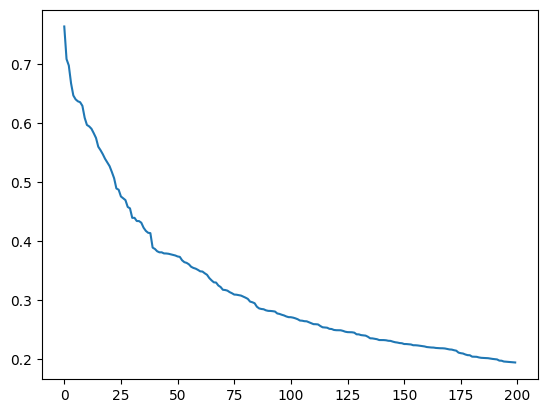

In [42]:
# Max
df.max().sort_values(ascending=False)[0:200].plot(use_index=False)

<AxesSubplot: >

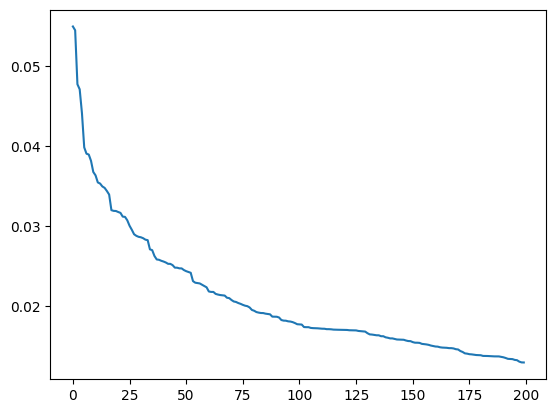

In [43]:
# Mean
df.mean().sort_values(ascending=False)[0:200].plot(use_index=False)

<AxesSubplot: >

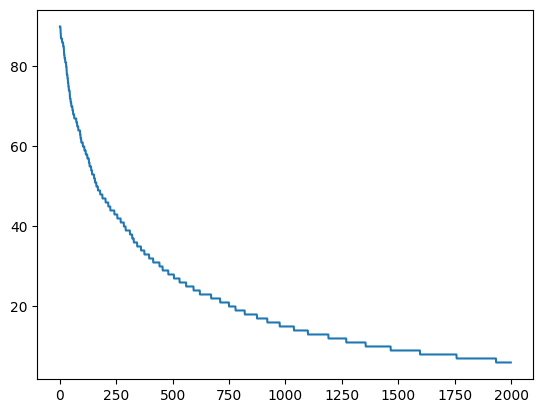

In [44]:
# Number of non-zero
df.astype(bool).sum(axis=0).sort_values(ascending=False)[0:2000].plot(use_index=False)

### Choose optimal number of clusters using scree plot, first for sklearn's kmeans algo

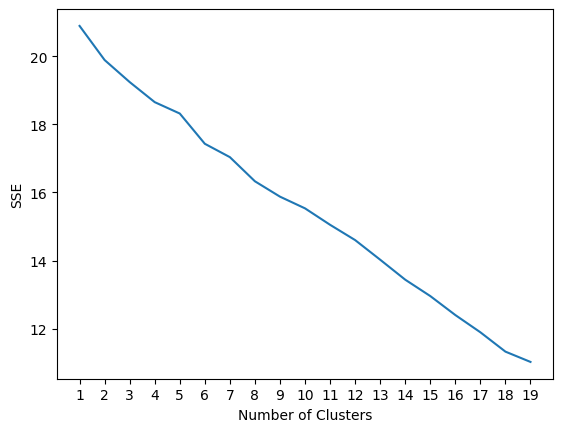

In [50]:
# for sklearn k-means algo - # max - ??? , mean - 12, nonzero - 12?
# Choose best by max value
num_words = 80
columns = df.max().sort_values(ascending=False)[0:num_words].index
# Choose best by mean value
#num_words = 100
#columns = df.mean().sort_values(ascending=False)[0:num_words].index
# Choose by number of non-zero values for each word
#num_words = 150
#columns = df.astype(bool).sum(axis=0).sort_values(ascending=False)[0:num_words].index

subset = df[columns]
# Find number of clusters for k-means clustering
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 33,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(subset.T)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### <A HREF="https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.TimeSeriesKMeans.html">TSLearn kMeans</A> k-means clustering for time series

### Choose optimal number of clusters using scree plot, now for tslearns's kmeans algo

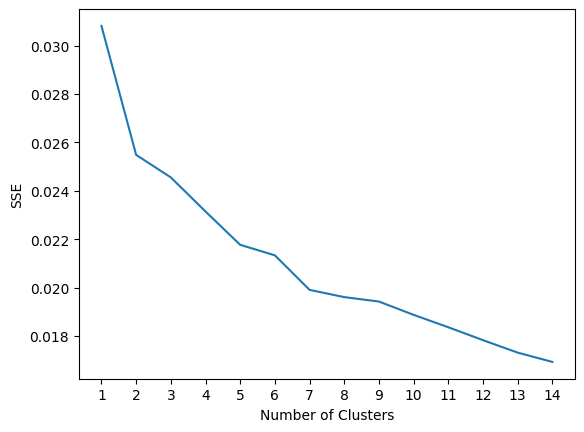

In [56]:
# for tslearn time series k-means algo - # max - 4 or 8, mean - 3 or 6, nonzero - 2 or 7
# Choose best by max value
#num_words = 80
#columns = df.max().sort_values(ascending=False)[0:num_words].index
# Choose best by mean value
#num_words = 100
#columns = df.mean().sort_values(ascending=False)[0:num_words].index
# Choose by number of non-zero values for each word
num_words = 150
columns = df.astype(bool).sum(axis=0).sort_values(ascending=False)[0:num_words].index

subset = df[columns]
# Find number of clusters for k-means clustering

#create list to hold SSE values for each k
sse = []
for k in range(1, 15):
    tskm = TimeSeriesKMeans(n_clusters=k, random_state=33, metric="dtw")
    tskm.fit_predict(subset.T)
    sse.append(tskm.inertia_)

#visualize results
plt.plot(range(1, 15), sse)
plt.xticks(range(1, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### function to return the tf-idf values for chosen words and the cluster labels

### algo: 'skl' for sk-learn and 'ts' for tslearn
### method: 'max', 'mean', 'nonzero' as described above

In [57]:
def cluster(df, algo, method, cluster_count):
    if method == 'max':
        # Choose best by max value
        num_words = 80
        columns = df.max().sort_values(ascending=False)[0:num_words].index
    elif method == 'mean':
        # Choose best by mean value
        num_words = 100
        columns = df.mean().sort_values(ascending=False)[0:num_words].index
    elif method == 'nonzero':
        # Choose by number of non-zero values for each word
        num_words = 150
        columns = df.astype(bool).sum(axis=0).sort_values(ascending=False)[0:num_words].index
    else:
        print('Choose a valid method: max, mean, nonzero')
        return False
    subset = df[columns]
    labelsdf = pd.DataFrame(columns=['label', 'word'])
    if algo == 'skl':
        kmeans = KMeans(n_clusters=cluster_count, **kmeans_kwargs).fit(subset.T)
        labelsdf['label'] = pd.DataFrame(list(kmeans.labels_))
    elif algo == 'ts':
        tskm = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")
        labelsdf['label'] = pd.DataFrame(tskm.fit_predict(subset.T))
    else:
        print('Choose a valid algo: skl, ts')
        return False
    labelsdf['word']= list(subset.columns)
    subsetdate = subset.copy()
    subsetdate['date']= text_df.index
    reshape = subsetdate.melt(var_name='word', value_name='tfidf', id_vars=['date'])
    reshape['dateint']=reshape['date'].apply(lambda x: x.value)
    reshape = pd.merge(reshape, labelsdf, on='word', how='left')
    # remove 2004 speech to make plot look nicer
    cutoff = pd.to_datetime('2008-01-01')
    reshape = reshape.query('date>@cutoff')
    reshape.sort_values('date', inplace=True, ignore_index=True)
    return([reshape, labelsdf])

### get results for all 6 combos of method and algo

In [58]:
# for sklearn k-means algo - # max - 4 or 5, mean - 9, nonzero - 2 to 5
# for tslearn time series k-means algo - # max - 7, mean - 4, nonzero - 2 or 6
# def cluster(df, algo, method, cluster_count)
reshapemax, labelsdfmax = cluster(df, 'skl', 'max', 10)
reshapemean, labelsdfmean = cluster(df, 'skl', 'mean', 12)
reshapenonzero, labelsdfnonzero = cluster(df, 'skl', 'nonzero', 12)
reshapetsmax, labelsdftsmax = cluster(df, 'ts', 'max', 8)
reshapetsmean, labelsdtsfmean = cluster(df, 'ts', 'mean', 6)
reshapetsnonzero, labelsdftsnonzero = cluster(df, 'ts', 'nonzero', 7)

/tmp/ipykernel_7184/3176125584.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_7184/3176125584.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_7184/3176125584.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_7184/3176125584.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

### Plots

In [59]:
plotthis = reshapemax.query('tfidf > 0.1')
fig = px.line(reshapemax, x='date', y='tfidf', color='label', hover_name='word')
fig.show()

In [60]:
fig = px.scatter(reshapemax, x="date", y="tfidf", color="label", hover_name="word", facet_col="label")
fig.show()

In [61]:
fig = px.line(reshapemean, x='date', y='tfidf', color='label', hover_name='word')
fig.show()

In [62]:
fig = px.line(reshapenonzero, x='date', y='tfidf', color='label', hover_name='word')
fig.show()

### Cluster lists for the 6 methods

In [69]:
# max sklearn
number = len(set(list(labelsdfmax['label'])))
for j in range(number):
    print(j)
    for i in range(len(labelsdfmax)):
        if labelsdfmax['label'].iloc[i] == j:
            print('\t',labelsdfmax['word'].iloc[i])

0
	 isil
	 oil
	 flint
	 egyptian
	 cuba
	 scalia
	 intel
	 space
	 boston
	 egypt
	 french
	 cuban
	 hillary
	 joplin
	 intelligence
	 fema
	 nelson
	 mandela
	 johnson
	 va
	 france
	 australia
	 nasa
	 shutdown
	 african
	 gabby
	 trade
	 kerry
	 college
	 church
	 aurora
	 outbreak
	 storm
	 approach
	 naval
	 detainee
	 leak
	 cyber
	 alan
	 berlin
	 immigration
	 guantanamo
	 catholic
	 gulf
	 loan
	 justice
	 financial
1
	 bush
	 president
2
	 mexico
3
	 gun
	 king
	 dr
	 job
	 child
4
	 insurance
	 health
5
	 iran
	 iranian
6
	 marriage
	 sex
	 think
7
	 afghan
	 bin
	 laden
	 qaida
	 war
	 qaeda
8
	 haiti
	 haitian
9
	 nuclear
	 ukraine
	 assad
	 iraq
	 veteran
	 europe
	 agreement
	 iraqi
	 chemical
	 russia


In [64]:
# mean sklearn
number = len(set(list(labelsdfmean['label'])))
for j in range(number):
    print(j)
    for i in range(len(labelsdfmean)):
        if labelsdfmean['label'].iloc[i] == j:
            print('\t',labelsdfmean['word'].iloc[i])

0
	 company
	 energy
	 oil
1
	 nuclear
2
	 america
	 new
3
	 child
	 life
	 president
	 man
	 tonight
	 love
	 hope
	 woman
	 may
	 fight
	 live
4
	 get
	 want
	 right
	 need
5
	 war
	 must
	 security
	 iraq
	 military
	 end
	 force
6
	 care
	 health
	 insurance
7
	 help
8
	 world
	 come
	 nation
	 today
	 change
	 economy
	 future
	 together
	 believe
	 action
9
	 job
	 business
10
	 think
	 state
11
	 american
	 americans
	 well
	 every
	 united
	 say
	 like
	 see
	 states
	 government
	 family
	 day
	 would
	 way
	 many
	 give
	 let
	 law
	 long
	 even
	 congress
	 keep
	 thank
	 pay
	 first
	 last
	 reform
	 great
	 thing
	 home
	 sure
	 create
	 stand
	 back
	 effort
	 support
	 act
	 million
	 could
	 community
	 build
	 hard
	 place
	 still
	 worker
	 two
	 everybody
	 much
	 continue
	 challenge
	 happen
	 lead
	 high
	 around


In [65]:
# non-zero sklearn
number = len(set(list(labelsdfnonzero['label'])))
for j in range(number):
    print(j)
    for i in range(len(labelsdfnonzero)):
        if labelsdfnonzero['label'].iloc[i] == j:
            print('\t',labelsdfnonzero['word'].iloc[i])

0
	 home
	 future
	 end
	 support
	 security
	 build
	 force
	 serve
1
	 around
	 speak
	 continue
	 across
	 bring
	 lead
	 meet
	 set
	 leader
	 put
	 face
	 include
	 grow
	 forward
	 challenge
	 fight
	 call
	 move
	 begin
	 clear
	 use
	 lose
	 without
	 strong
	 week
	 already
	 share
	 past
	 hold
	 leave
	 another
	 learn
	 always
	 understand
	 step
	 bless
	 protect
	 decade
	 small
	 responsibility
	 true
	 far
	 since
	 month
	 national
2
	 much
	 place
	 community
	 think
	 everybody
	 happen
	 law
	 part
	 fact
	 state
	 ask
	 issue
	 mean
	 important
	 try
	 able
	 something
3
	 america
	 world
	 nation
4
	 thank
	 day
	 family
	 life
	 many
	 first
	 president
	 great
	 man
	 woman
	 could
	 child
	 may
	 god
	 live
	 hope
5
	 job
	 economy
	 business
6
	 get
7
	 new
	 let
	 high
	 congress
	 pay
8
	 today
	 say
	 american
	 every
	 well
	 way
	 want
	 need
	 right
	 come
	 like
	 help
	 americans
	 see
	 would
	 change
9
	 united
	 states
	 stand
	 effort
	 power
	 nev

In [66]:
# max tslearn
number = len(set(list(labelsdftsmax['label'])))
for j in range(number):
    print(j)
    for i in range(len(labelsdftsmax)):
        if labelsdftsmax['label'].iloc[i] == j:
            print('\t',labelsdftsmax['word'].iloc[i])

0
	 health
	 college
	 president
	 think
	 child
1
	 mexico
	 flint
	 egyptian
	 cuba
	 scalia
	 intel
	 space
	 ukraine
	 boston
	 assad
	 egypt
	 haiti
	 cuban
	 veteran
	 hillary
	 joplin
2
	 isil
	 iran
	 nuclear
	 iranian
3
	 king
	 bush
	 intelligence
	 fema
	 nelson
	 mandela
	 johnson
	 dr
	 va
	 australia
	 haitian
	 nasa
	 marriage
	 shutdown
	 bin
	 laden
	 african
	 gabby
	 trade
	 kerry
	 church
	 aurora
	 outbreak
	 qaida
	 approach
	 naval
	 detainee
	 leak
	 cyber
	 chemical
	 alan
	 sex
	 berlin
	 immigration
	 guantanamo
	 catholic
4
	 oil
	 gun
	 insurance
	 french
5
	 iraq
6
	 europe
	 france
	 afghan
	 agreement
	 storm
	 iraqi
	 qaeda
	 russia
	 gulf
	 loan
	 justice
	 financial
7
	 war
	 job


In [67]:
# mean tslearn
number = len(set(list(labelsdtsfmean['label'])))
for j in range(number):
    print(j)
    for i in range(len(labelsdtsfmean)):
        if labelsdtsfmean['label'].iloc[i] == j:
            print('\t',labelsdtsfmean['word'].iloc[i])

0
	 america
	 world
	 new
	 come
	 nation
	 american
	 americans
	 help
	 like
	 business
	 economy
	 future
	 security
	 congress
	 create
	 hope
	 action
1
	 iraq
	 insurance
	 nuclear
	 oil
2
	 right
	 united
	 states
	 government
	 day
	 would
	 child
	 life
	 man
	 pay
	 home
	 sure
	 stand
	 love
	 effort
	 state
	 act
	 community
	 build
	 place
	 end
	 worker
	 two
	 challenge
	 force
	 happen
	 high
3
	 get
	 job
	 change
	 law
	 company
	 energy
	 reform
4
	 war
	 must
	 think
	 president
	 care
	 tonight
	 health
	 military
5
	 want
	 well
	 today
	 need
	 every
	 say
	 see
	 family
	 way
	 many
	 give
	 let
	 together
	 long
	 even
	 believe
	 keep
	 thank
	 first
	 last
	 great
	 thing
	 back
	 support
	 million
	 could
	 hard
	 woman
	 still
	 may
	 everybody
	 much
	 continue
	 fight
	 lead
	 live
	 around


In [68]:
# non-zero tslearn
number = len(set(list(labelsdftsnonzero['label'])))
for j in range(number):
    print(j)
    for i in range(len(labelsdftsnonzero)):
        if labelsdftsnonzero['label'].iloc[i] == j:
            print('\t',labelsdftsnonzero['word'].iloc[i])

0
	 today
	 say
	 thank
	 way
	 family
	 give
	 life
	 many
	 together
	 first
	 even
	 see
	 last
	 great
	 back
	 let
	 long
	 keep
	 home
	 future
	 end
	 support
	 economy
	 everybody
	 thing
	 challenge
	 step
	 protect
1
	 american
	 every
	 well
	 want
	 need
	 right
	 come
	 united
	 states
	 like
	 help
	 americans
	 government
	 security
	 pay
2
	 stand
	 place
	 man
	 community
	 effort
	 believe
	 forward
	 tell
	 build
	 law
	 god
	 sure
	 lose
	 state
	 million
	 create
	 generation
	 act
	 high
	 force
	 small
	 hope
	 serve
3
	 america
	 world
	 new
	 get
4
	 much
	 around
	 speak
	 still
	 continue
	 across
	 hard
	 woman
	 bring
	 lead
	 meet
	 two
	 set
	 leader
	 put
	 could
	 face
	 look
	 include
	 may
	 grow
	 ago
	 power
	 never
	 start
	 happen
	 history
	 fight
	 call
	 move
	 part
	 begin
	 next
	 clear
	 use
	 opportunity
	 without
	 fact
	 strong
	 ask
	 issue
	 live
	 week
	 already
	 mean
	 share
	 important
	 try
	 past
	 hold
	 leave
	 young
	 another
	